## Шаг 1. Исследовательский анализ данных

Загрузим библиотеки и данные.

In [1]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка содержит 7591 запись. Не слишком много, попробую использовать ResNet.  
Пропусков не обнаружено.

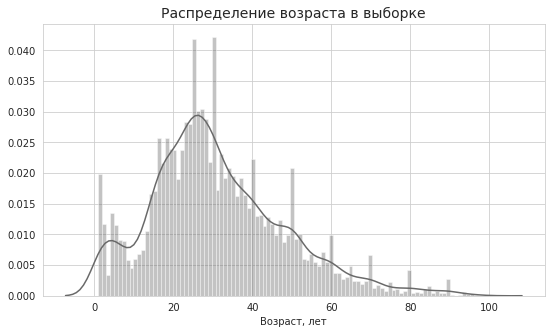

In [5]:
plt.figure(figsize=(9,5))
sns.distplot(faces['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

In [6]:
faces['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Датасет содержит информацию о фотографиях людей от 1 года до 100 лет.  
Основная часть людей на изображениях в возрасте 20-30 лет c пиками 25 и 30 лет.   
Годовалых младенцев больше, чем 10-12 летних детей.  
Встречаются повышенное количество людей в возрасте 40, 50, 60, 70, 80, 90 лет.

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=faces,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=10,
        class_mode='raw',
        seed=43)

Found 7591 validated image filenames.


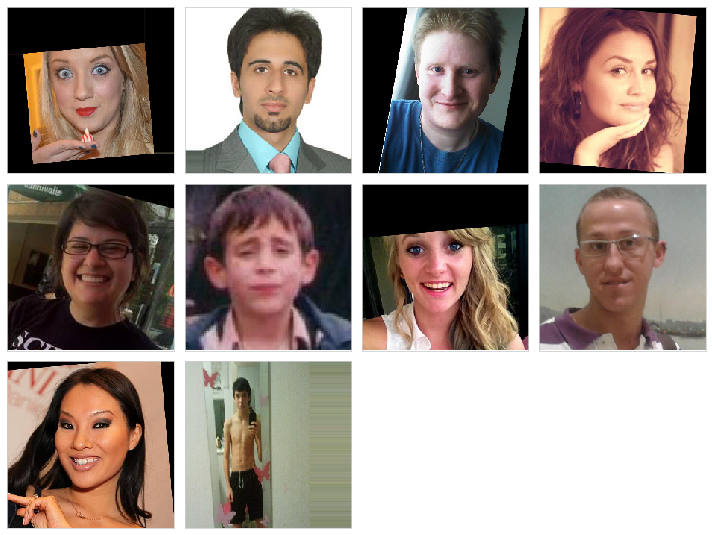

In [8]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Ох, как последнего парня сжало =)   
Интересно, что в полученной  подвыборке 5 женщин и 5 мужчин.  
Встречаются черно-белые и цветные фотографии (в первой тетрадке реально встречались).

### Вывод  

Выборка содердит 7591 запись.  
Целевой признак несбалансирован.  
Больше всего людей в возрасте от 20 до 30 лет, в каждой десятилетней группе выделяются "круглые юбиляры".  
Выдвину предположение о сдвиги предсказаний модели в сторону "молодых людей" 20-30 лет. И тяготении модели к круглым датам. 

---

# 2. Обучение модели

#### Код модели

```python
###Загрузка лейблов. при выполнении в одном окне - можно было бы взять предыдущий датасет  

labels = pd.read_csv('/datasets/faces/labels.csv')

###Загрузка обучающей подвыборки

def load_train(path):

    train_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
        #horizontal_flip=True,
        #rotation_range=45
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_gen_flow

###Загрузка тестовой подвыборки

def load_test(path):

    test_datagen = ImageDataGenerator(
        validation_split=0.20,
        rescale=1./255
        )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow


### Создание модели     

### Я использовал архитектуру ResNet. Основные слои предобучены на ImageNet   
### Финальный слой представлен одним нейроном и активацией ReLU  

def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model

### Обучение модели

def train_model(model, train_data, test_data, batch_size=None, 
                epochs=5, steps_per_epoch=None, validation_steps=None):
    

    if steps_per_epoch is None:
                 steps_per_epoch = len(train_data)
    if validation_steps is None:
                  validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,        
              verbose=2, 
              shuffle=True)

    return model
```

### Процесс обучения  

```python

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 380 steps, validate for 95 steps

Epoch 1/5
380/380 - 51s - loss: 197.9422 - mae: 10.3301 - val_loss: 645.2110 - val_mae: 19.9745
                
Epoch 2/5
380/380 - 41s - loss: 70.4338 - mae: 6.3642 - val_loss: 134.0160 - val_mae: 8.7018
                
Epoch 3/5
380/380 - 42s - loss: 37.5852 - mae: 4.7263 - val_loss: 86.2851 - val_mae: 7.2871

Epoch 4/5
380/380 - 41s - loss: 21.8109 - mae: 3.6205 - val_loss: 80.1763 - val_mae: 6.9830

Epoch 5/5
380/380 - 42s - loss: 16.2222 - mae: 3.0886 - val_loss: 67.6097 - val_mae: 6.2701

95/95 - 9s - loss: 67.6097 - mae: 6.2701
        
```

Финальная МАЕ на валидационной выборке = 6.27. Приемленый результат в рамках исследования. 

### Вывод  

На данном этапе я произвел создание нейронной сети с архитектурой ResNet. Сверточные слои были предобучены на ImageNet. 
Обучение модели проходило в течение 5 эпох с learning rate = 0.0001 и алгоритмом Аdam.  

В результате МАЕ на обучающей выборке = 3.089, на валидационной 6.270. Переобучения не обнаружено. Результат лучше 7.  

---

## 3. Анализ обученной модели

На валидационной выборке обученная модель ошибается в среднем на 6 лет. Я уверен, что при настройке параметров, можно добиться лучших показателей.   
Обучение 1 эпохи происходит в течение 41-42 секунд.  

---

## Общий вывод

Цель исследования выполнена: обученная модель демонстрирует показатель MAE = 6.27 без настройки параметров и аугментации данных.  

Исходные данные содержали 7.5 тысяч записей, без пропусков и выбросов. 
Большинство людей на фотографиях запечетлено в возрастном диапазоне 20-30 лет. В каждой 10-летней группе встречается повышенное количество круглых юбиляров (50-60-70 лет).
Модель содержит архитектуру ResNet и предобученные на ImageNet сверточные слои.  

---